# Homework 1
## Due Wednesday September 27
Use a Chebyshev method to solve the second order ordinary differential equation
$$ u''(t) + a u'(t) + b u(t) = f(t) $$
from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.
Do a grid convergence study to test the accuracy of your method.
Setting $f(x)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.
______________________________________________________________________________________________

In [ ]:
import numpy
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def cosspace(a, b, n=50):
    """This is exact code from @jedbrown 's FDHighOrder notebook"""
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(-numpy.pi, 0, n)))

## Adjusting for the interval
The first step in using a Chebyshev method to solve this ODE is recognizing that the Chebyshev polynomials that we have built and used in class thus far have been created under the assumption that the polynomials are on the interval $[1, 1]$.

For this problem, however, we are solving the second order ODE on the interval $[0, 1]$. Therefore we must alter our existing Chebyshev polynomial matrix to reflect this half range.

From [1] we know that on the interval, $[a,b]$, the shifted Chebyshev polynomial is,
$$T_n\left(\frac{2x-(a+b)}{(b-a)}\right).$$
Specifically for the half-range Chebyshev polynomial, $T^*_n$, this recurrence relation is defined as,
$$\begin{align}
T^*_0(x) & =1\\
T^*_1(x) & =2x-1\\
T^*_{n+1}(x) &=(4x-2)T^*_n(x)-T^*_{n-1}(x).
\end{align}$$

Similarly, the recurrence relation for the first derivative, $T^*_n`(x)$ is defined as,
$$
\begin{align}
T^*_0`(x) & =0\\
T^*_1`(x) & =2\\
T^*_2`(x) & =16x-2\\
T^*_{n+1}`(x) &=(n+1)\left[4T^*_n(x)+\frac{T^*_{n-1}`(x)}{(n-1)}\right].
\end{align}
$$
The recurrence relation for the second derivative, $T^*_n``(x)$ is defined as,

$$\begin{align}
T^*_0``(x) & =0\\
T^*_1``(x) & =0\\
T^*_2``(x) & =16\\
T^*_{n+1}``(x) &=(n+1)\left[4T^*_n`(x)+\frac{T^*_{n-1}``(x)}{(n-1)}\right].
\end{align}$$
With these definitions for the half-range Chebyshev polynomial, we alter the in-class definitions of $\verb|vander_chebyshev|$ and $\verb|chebeval|$ as follows:

In [16]:
def vander_half_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = numpy.ones((len(x), n))
    if n > 1:
        T[:,1] = 2*x -1 #Shifted!
    for k in range(2,n):
        T[:,k] = (4*x - 2) * T[:,k-1] - T[:,k-2] #SHIFTED!
    return T

def half_chebeval(z, n=None):
    z = numpy.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_half_chebyshev(z, n)
    dTz = numpy.zeros_like(Tz)
    dTz[:,1] = 2 #shifted
    dTz[:,2] = 16*z-8 #shifted
    ddTz = numpy.zeros_like(Tz)
    ddTz[:,2] = 16
    for n in range(3,n):
        dTz[:,n]  = n * (4*Tz[:,n-1] + dTz[:,n-2]/(n-2)) #shifted
        ddTz[:,n] = n * (4*dTz[:,n-1] + ddTz[:,n-2]/(n-2)) #shifted
    return [Tz, dTz, ddTz]

## The Analytic Solution
When $f(x)=0$, we solve the linear second order ODE analytically by finding the roots of the characteristic equation,
$$r^2+ar+b=0.$$
The roots for arbitrary $a$ and $b$ are $$r_{1,2}=\frac{-a}{2} \pm \frac{\sqrt{a^2-4b}}{2}.$$
When $r_{1,2}$ are real, the solution to the ODE is 
$$u(t)=c_1e^{r_1t}+c_2e^{r_2t}.$$
When $r_{1,2}$ are complex, the solution to the ODE is
$$u(t)=e^{\frac{-a}{2}t}\left(c_1\cos(\frac{\sqrt{a^2-4b}}{2}t)+c_2\sin(\frac{\sqrt{a^2-4b}}{2}t)\right).$$
This differing behaviour of the solution depending on $a,b$ will be seen in later numerical experiments.

For the purposes of our convergence studies, we set $(a,b)=(3,2)$. The exact solution of the ODE is then,
$$u(t)=2e^{-t}-e^{-2t}.$$

In [19]:
def analytic_soln(t):
    return 2*numpy.exp(-t)-numpy.exp(-2*t)

## Approximating the solution
We alter the in-class code for $\verb|laplacian_cheb|$ to reflect the ODE with $a=3$, $b=2$, and $f(x)=0$, and set the boundary conditions accordingly. 

In [20]:
def laplacian_half_cheb(n, rhsfunc, a, b):
    """The function's skeleton are being used from @jedbrown 's FDHighOrder notebook"""
    x = cosspace(0, 1, n+1) #Half Range
    
    T = half_chebeval(x)

    L = T[2] + a * T[1] + b* T[0] #The second order linear ODE
    
    rhs = numpy.zeros(n+3)
    rhs = rhsfunc(x)
    
    L[0] = T[0][0] #u(0)=1
    rhs[0] = 1 #u(0)=1
    L[1] = T[1][0] #u'(0)=0
    rhs[1] = 0 #u'(0)=0
    
    return x, L.dot(numpy.linalg.inv(T[0])), rhs

a=3; b=2;
xx = numpy.linspace(0,1,100)    
x, L, rhs = laplacian_half_cheb(20, lambda x: 0*x, a, b)

We plot the analyitic solution and the Chebyshev approximation.

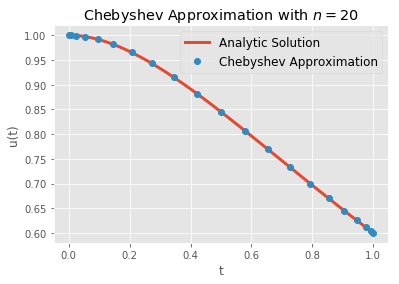

In [24]:
plt.plot(xx, analytic_soln(xx), label='Analytic Solution', linewidth='3')
plt.plot(x, numpy.linalg.solve(L, rhs), 'o', label='Chebyshev Approximation')
plt.xlabel('t',fontsize=12)
plt.ylabel('u(t)',fontsize=12)
plt.legend(loc="best",fontsize=12)
plt.title(r'Chebyshev Approximation with $n=20$')
plt.show()

## Convergence Study
We use the infinity norm and the analytic solution to compute the absolute error in the Chebyshev polynomial with increasing grid size, $n$. 

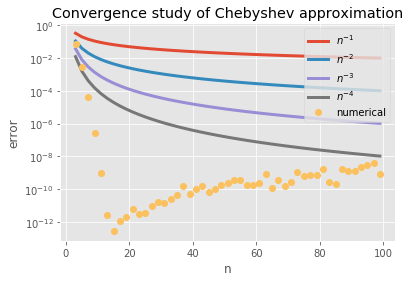

In [29]:
ns = numpy.arange(3,100,2)
errors = numpy.zeros(len(ns))
i=0
for n in ns:
    x, L, rhs = laplacian_half_cheb(n, lambda x: 0*x, a, b)
    u = numpy.linalg.solve(L, rhs)
    re = analytic_soln(x)
    errors[i] = numpy.linalg.norm(u - re, numpy.inf)
    i += 1

plt.figure()
for p in range(1,5):
    plt.semilogy(ns, 1/ns**(p), label='$n^{-%d}$'%p, linewidth='3')
plt.semilogy(ns, errors, 'o', label='numerical')
plt.xlabel('n',fontsize=12)
plt.ylabel('error',fontsize=12)
plt.title(r'Convergence study of Chebyshev approximation')
plt.legend(loc='upper right',fontsize=10);
plt.show()

Note the spectral convergence in this method for the first 20 points. As we continue to increase the grid size, however, the error in this method increases. 

## Experimenting with $a$ and $b$

As previously noted, the values of $a$ and $b$ define whether or not the roots of the characteristic equation for the ODE are real or complex. Thus they also define whether the solution of the ODE is 
$$u(t)=c_1e^{r_1t}+c_2e^{r_2t},$$
or
$$u(t)=e^{\frac{-a}{2}t}\left(c_1\cos(\frac{\sqrt{a^2-4b}}{2}t)+c_2\sin(\frac{\sqrt{a^2-4b}}{2}t)\right),$$
for real and complex roots, respectively.
This behaviour is visible in the following experiments in varying $a$ and $b$.

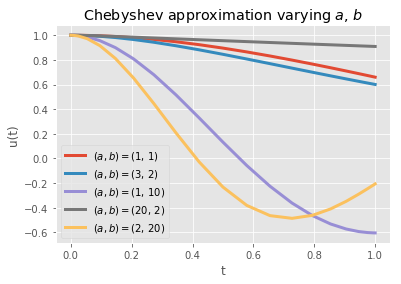

In [30]:
n=18
aes_and_bees = [(1,1), (3,2), (1,10), (20,2), (2,20)] 
u=numpy.zeros((n,len(aes_and_bees)))
i=0 
for ab in aes_and_bees:
    a,b = ab
    x, L, rhs = laplacian_half_cheb(20, lambda x: 0*x, a, b)
    plt.plot(x, numpy.linalg.solve(L, rhs), label='$(a,b)=$'+str(ab), linewidth='3')

plt.xlabel('t',fontsize=12)
plt.ylabel('u(t)',fontsize=12)
plt.legend(loc="best",fontsize=10)
plt.title(r'Chebyshev approximation varying $a$, $b$')
plt.show()